<a href="https://colab.research.google.com/github/kshashank03/data-science-projects/blob/master/Regression_Models/California_housing_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# California Housing Prices
## Shashank Kalanithi

# Preparing Workspace
## Installing and Importing Libraries

In [6]:
###*** Download packages for Basemap ***###
'''
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
'''

'\n!apt-get install libgeos-3.5.0\n!apt-get install libgeos-dev\n!pip install https://github.com/matplotlib/basemap/archive/master.zip\n'

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

## Importing Base Dataset for Easy Access

In [78]:
dataset_path = "/content/drive/My Drive/Data Science/1990 California Housing/housing.csv"

dataset = pd.read_csv(dataset_path)
dataset.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


# Data Preparation and Visualization
## Train-Test Split of Our Data

This should be done before any analysis in order to prevent Data Snooping bias

In [46]:
housing_data = dataset.copy() #Take a copy so we can revert back to the original dataset if needed

housing_data["income_cat"] = pd.cut(housing_data["median_income"], 
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf], 
                               labels=[1, 2, 3, 4, 5])

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing_data, housing_data["income_cat"]):
  strat_train_set = housing_data.loc[train_index]
  strat_test_set = housing_data.loc[test_index]

strat_test_set.drop("income_cat", axis=1, inplace=True)
strat_train_set.drop("income_cat", axis=1, inplace=True)

## Plotting Histograms and Maps of our Variables

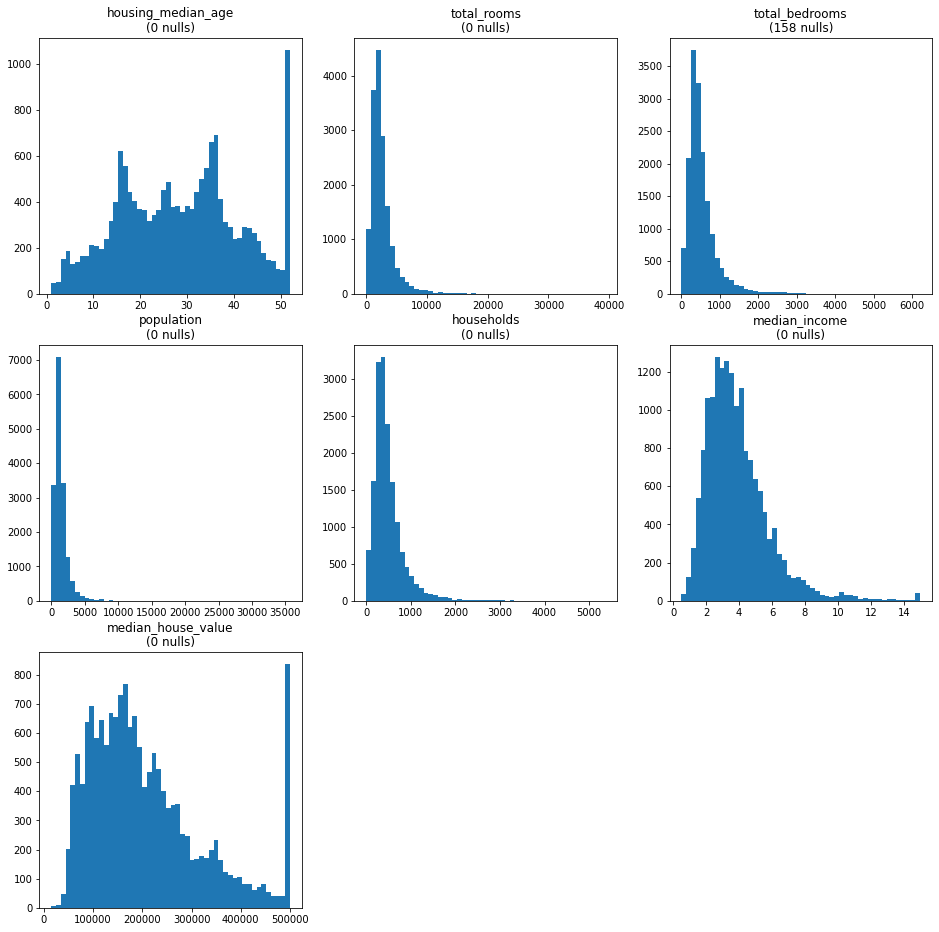

In [92]:
hist_data = strat_train_set.copy()
hist_data = hist_data.loc[:, ["housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"]]
hist_nas = hist_data.isna().sum()
hist_data.dropna(inplace=True)

plt.figure(figsize=(16, 16))

for i in range(1, 8):
  plt.subplot(3, 3, i)
  plt.hist(hist_data.iloc[:, i-1], bins=50)
  plt.title(hist_data.columns[i - 1] + f"\n({hist_nas[i-1]} nulls)")



## Maps of Variables vs. Median Income

In [93]:
map_data = strat_train_set.copy()
lat = map_data['latitude'].values
lon = map_data['longitude'].values
housing_price = np.log10(map_data['median_house_value']) * 5

map_data = map_data.loc[:, ["latitude", "longitude", "median_house_value", 
                            "housing_median_age", "total_rooms", 
                            "total_bedrooms", "population", "households", 
                            "median_income"]]

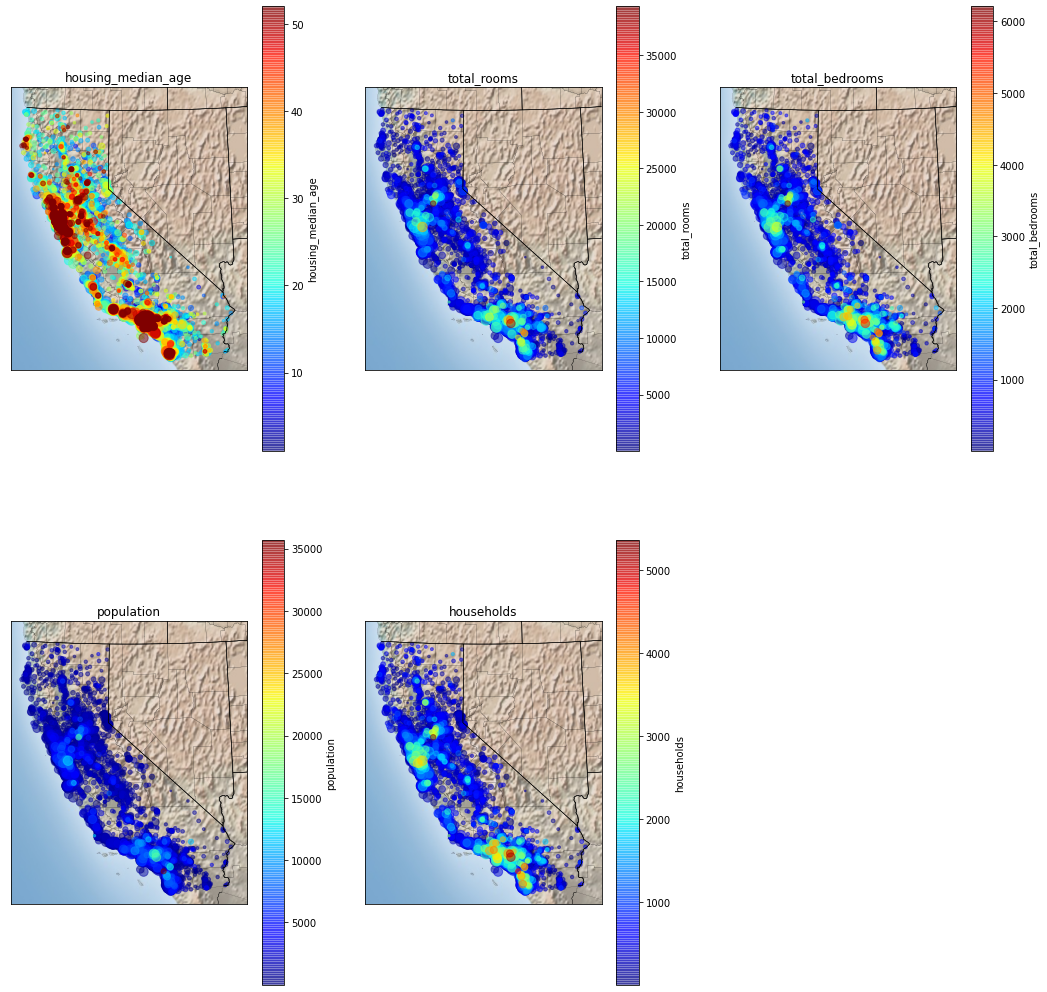

In [49]:
fig = plt.figure(figsize=(18, 18))
m = Basemap(projection='lcc', resolution='h', 
            lat_0=37.5, lon_0=-119,
            width=1E6, height=1.2E6)

for i in range(4, len(map_data.columns)):
  plt.subplot(2, 3, i - 3)
  plt.title(map_data.columns[i - 1])
  map_data2 = map_data.copy()
  map_data2.sort_values(by=[map_data2.columns[i - 1]], ascending= True, inplace=True)
  m.shadedrelief()
  m.drawcounties(color='k')
  m.drawstates(color='black')
  m.scatter(map_data2['longitude'].values, map_data2['latitude'].values, latlon=True,
          c=map_data2.iloc[:,i - 1], s=((map_data2['median_house_value']/5000).values), 
          cmap='jet', alpha=0.5)
  plt.colorbar(label=map_data2.columns[i - 1])
  plt.clim(1, max(map_data2.iloc[:,i - 1]))

## Checking for Correlations in our Data
### Light Feature Engineering

In [50]:
corr_matrix = strat_train_set.copy()
corr_matrix = corr_matrix.corr()

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [51]:
### Experimenting with attribute combinations

strat_train_set["rooms_per_household"] = strat_train_set["total_rooms"]/
strat_train_set["households"]
strat_test_set["rooms_per_household"] = strat_test_set["total_rooms"]/
strat_test_set["households"]

strat_train_set["bedrooms_per_room"] = strat_train_set["total_bedrooms"]/
strat_train_set["total_rooms"]
strat_test_set["bedrooms_per_room"] = strat_test_set["total_bedrooms"]/
strat_test_set["total_rooms"]

strat_train_set["population_per_household"] = strat_train_set["population"]/
strat_train_set["households"]
strat_test_set["population_per_household"] = strat_test_set["population"]/
strat_test_set["households"]

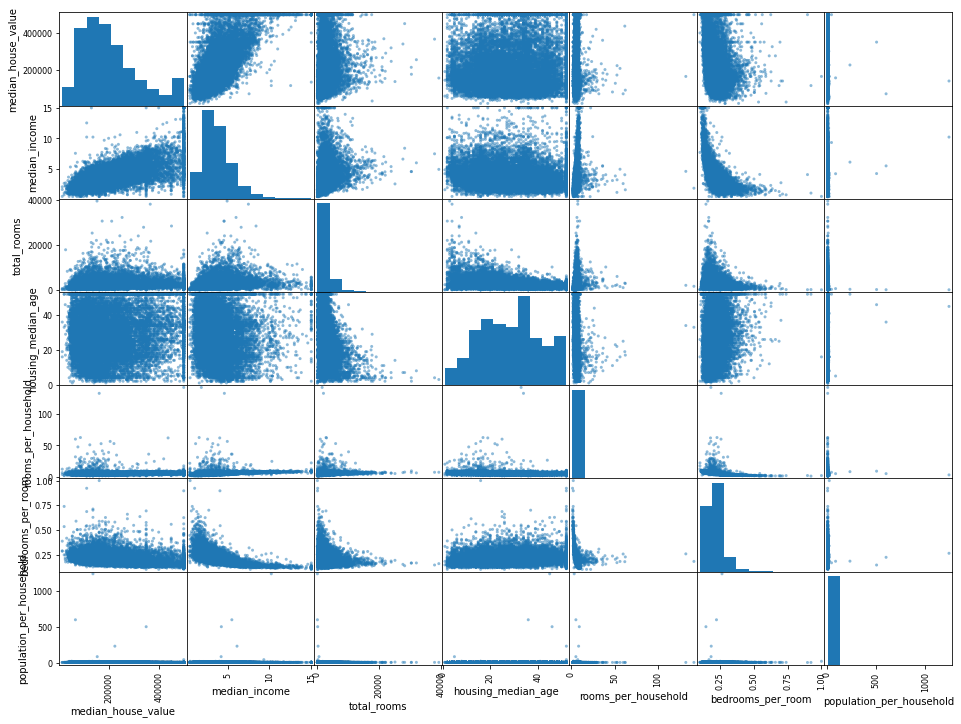

In [95]:
# Plotting scatter matrices for most well correlated variables
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", 
              "housing_median_age", "rooms_per_household", "bedrooms_per_room", 
              "population_per_household"]

scatter_matrix(strat_train_set[attributes], figsize = (16, 12))
# In order to not just have vertical lines on the diagonal where it's plotting against itself, pandas plots a histogram

## Impute Values

In [53]:
x_columns = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
             "median_income", "ocean_proximity", "rooms_per_household", "bedrooms_per_room", "population_per_household"]

y_column = "median_house_value"

X_train = strat_train_set.loc[:, x_columns]
X_test = strat_test_set.loc[:, x_columns]
y_train = strat_train_set.loc[:, y_column]
y_test = strat_test_set.loc[:, y_column]

def impute_automater(df, strategy): #Function to impute just the numerical values in a dataframe
  from sklearn.impute import SimpleImputer
  imputer = SimpleImputer(strategy=strategy)

  numericals = df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
  categoricals = df.select_dtypes(exclude=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])

  numericals = pd.DataFrame(imputer.fit_transform(numericals), columns=df.select_dtypes(
      include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns, index=df.index)

  return numericals.merge(categoricals, left_index=True, right_index=True)

  
X_train = impute_automater(X_train, "median")
X_test = impute_automater(X_test, "median")

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [-1])], remainder='passthrough')

X_train = ct.fit_transform(X_train)
X_test = ct.fit_transform(X_test)

## Split Data Into X and Y

In [96]:
###*** Separate Data Into Train and Test Sets and X and Y ***###
x_columns = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
             "median_income", "ocean_proximity", "rooms_per_household", "bedrooms_per_room", "population_per_household"]

y_column = "median_house_value"

X_train = strat_train_set.loc[:, x_columns]
X_test = strat_test_set.loc[:, x_columns]
y_train = strat_train_set.loc[:, y_column]
y_test = strat_test_set.loc[:, y_column]

numericals = X_train.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])

categoricals = X_train.select_dtypes(exclude=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])

## Build out Data Pipelines

In [97]:
###*** Build out Pipelines ***###
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
                         ("imputer", SimpleImputer(strategy="median")),
                         #("attribs_adder", CombinedAttributesAdder()),
                         ("std_scaler", StandardScaler()),
])

full_pipeline = ColumnTransformer([
                                   ("num", num_pipeline, numericals.columns), 
                                   ("cat", OneHotEncoder(), categoricals.columns),
])

X_train = full_pipeline.fit_transform(X_train)
X_train

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

# Models and Evaluation

## Models

### Linear Regression Model

In [55]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error

lin_reg_preds = lin_reg.predict(X_train)
lin_mse = mean_squared_error(y_train, lin_reg_preds)
lin_rmse = np.sqrt(lin_mse)
lin_rmse


68161.22644433199

### Decision Tree Model

In [56]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

tree_preds = tree_reg.predict(X_train)
tree_mse = mean_squared_error(y_train, tree_preds)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

### Random Forest Model

In [57]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train)

forest_reg_preds = forest_reg.predict(X_train)
forest_reg_mse = mean_squared_error(y_train, forest_reg_preds)
forest_reg_rmse = np.sqrt(forest_reg_mse)
forest_reg_rmse

18783.4992994513

## Evaluating Models

### Score Models Using Cross Validation

In [58]:
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("StdDev:", scores.std())

from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(lin_reg, X_train, y_train, 
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66060.65470195 66764.30726969 67721.72734022 74719.28193624
 68058.11572078 70909.35812986 64171.66459204 68075.65317717
 71024.84033989 67300.24394751]
Mean: 68480.58471553597
StdDev: 2845.584309265082


In [59]:
tree_scores = cross_val_score(tree_reg, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

display_scores(tree_rmse_scores)

Scores: [71683.5631741  66237.25587632 70153.39854028 69836.13002055
 70777.88714156 73893.93501187 70995.50898459 69991.41193866
 76593.01048505 69873.07806446]
Mean: 71003.51792374442
StdDev: 2592.5928558027035


In [60]:
forest_reg_scores = cross_val_score(forest_reg, X_train, y_train,
                                    scoring = "neg_mean_squared_error", cv=10)
forest_reg_rmse_scores = np.sqrt(-forest_reg_scores)
display_scores(forest_reg_rmse_scores)

Scores: [49640.67335678 47530.97268196 49497.65095041 52472.20444359
 49382.34144575 53417.15851436 48707.17553763 47845.87340917
 52934.49550428 49782.1057503 ]
Mean: 50121.06515942284
StdDev: 1986.7477397602001


### Grid Search to Optimize Hyperparameters

In [61]:
from sklearn.model_selection import GridSearchCV

param_grid = [
              {"n_estimators": [3, 10, 30], "max_features":[2, 4, 6, 8]},
              {"bootstrap":[False], "n_estimators":[3, 10], "max_features":[2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring="neg_mean_squared_error",
                           return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [62]:
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'max_features': 6, 'n_estimators': 30}
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


In [63]:
cvres = grid_search.cv_results_
for mean_score, params, in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

64873.55400587145 {'max_features': 2, 'n_estimators': 3}
55753.94037768231 {'max_features': 2, 'n_estimators': 10}
52806.18706259411 {'max_features': 2, 'n_estimators': 30}
59868.821150956115 {'max_features': 4, 'n_estimators': 3}
52805.8612730476 {'max_features': 4, 'n_estimators': 10}
50419.20948422488 {'max_features': 4, 'n_estimators': 30}
58804.863033877366 {'max_features': 6, 'n_estimators': 3}
52222.97250341705 {'max_features': 6, 'n_estimators': 10}
49969.1268119625 {'max_features': 6, 'n_estimators': 30}
58321.09024580792 {'max_features': 8, 'n_estimators': 3}
52604.32723252397 {'max_features': 8, 'n_estimators': 10}
50135.7982046309 {'max_features': 8, 'n_estimators': 30}
62624.34404425618 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54604.90979421681 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60068.84235993183 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52729.61265957618 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}

### Check the Importance of Each Feature

In [76]:
feature_importances = grid_search.best_estimator_.feature_importances_
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = list(numericals.columns)  + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.34291052312026576, 'median_income'),
 (0.13144047442942716, 'INLAND'),
 (0.10858011721811507, 'population_per_household'),
 (0.07761704880667443, 'longitude'),
 (0.07207635277436054, 'latitude'),
 (0.06574140027907341, 'bedrooms_per_room'),
 (0.06356473871539842, 'rooms_per_household'),
 (0.04195344654538435, 'housing_median_age'),
 (0.01872902041274354, 'total_rooms'),
 (0.018662256669522412, '<1H OCEAN'),
 (0.017299523575234736, 'population'),
 (0.016612096096153318, 'total_bedrooms'),
 (0.015701568908236273, 'households'),
 (0.0052762001513040726, 'NEAR OCEAN'),
 (0.003771748595231811, 'NEAR BAY'),
 (6.348370287472256e-05, 'ISLAND')]